# Kaggle Houses

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from copy import deepcopy
import seaborn as sns
from sklearn.decomposition import PCA,KernelPCA
import scipy as sp

### Loading data..

In [2]:
train = read_csv('KaggleHousePricesAdvancedRegressionTechniques/train.csv')
test = read_csv('KaggleHousePricesAdvancedRegressionTechniques/test.csv')

In [3]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [4]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [5]:
numeric = pd.DataFrame(train.select_dtypes(include=[np.number]))
correlation = numeric.corr()
columns = np.absolute(correlation).nlargest(36,'SalePrice')['SalePrice'].index
numeric = pd.DataFrame(np.sort(columns, axis=-1, kind='quicksort', order=None))
correlation = numeric.corr()

cm = np.corrcoef(train[columns].apply(lambda x: x.fillna(x.mean()),axis=0).values.T)
plt.subplots(figsize = (10, 8.5))
sns.heatmap(cm,xticklabels = columns.values, yticklabels = columns.values)
plt.show()

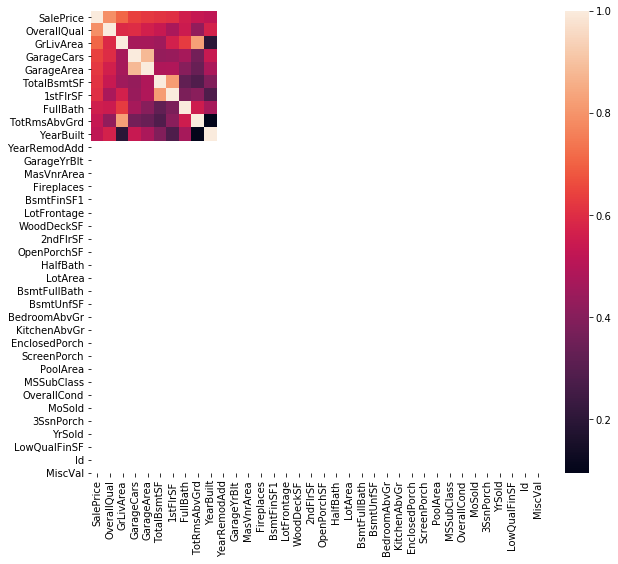

In [6]:
cm = np.corrcoef(train[columns[:10]].apply(lambda x: x.fillna(x.mean()),axis=0).values.T)
plt.subplots(figsize = (10, 8.5))
sns.heatmap(cm,xticklabels = columns.values, yticklabels = columns.values)
plt.show()

## Outliers

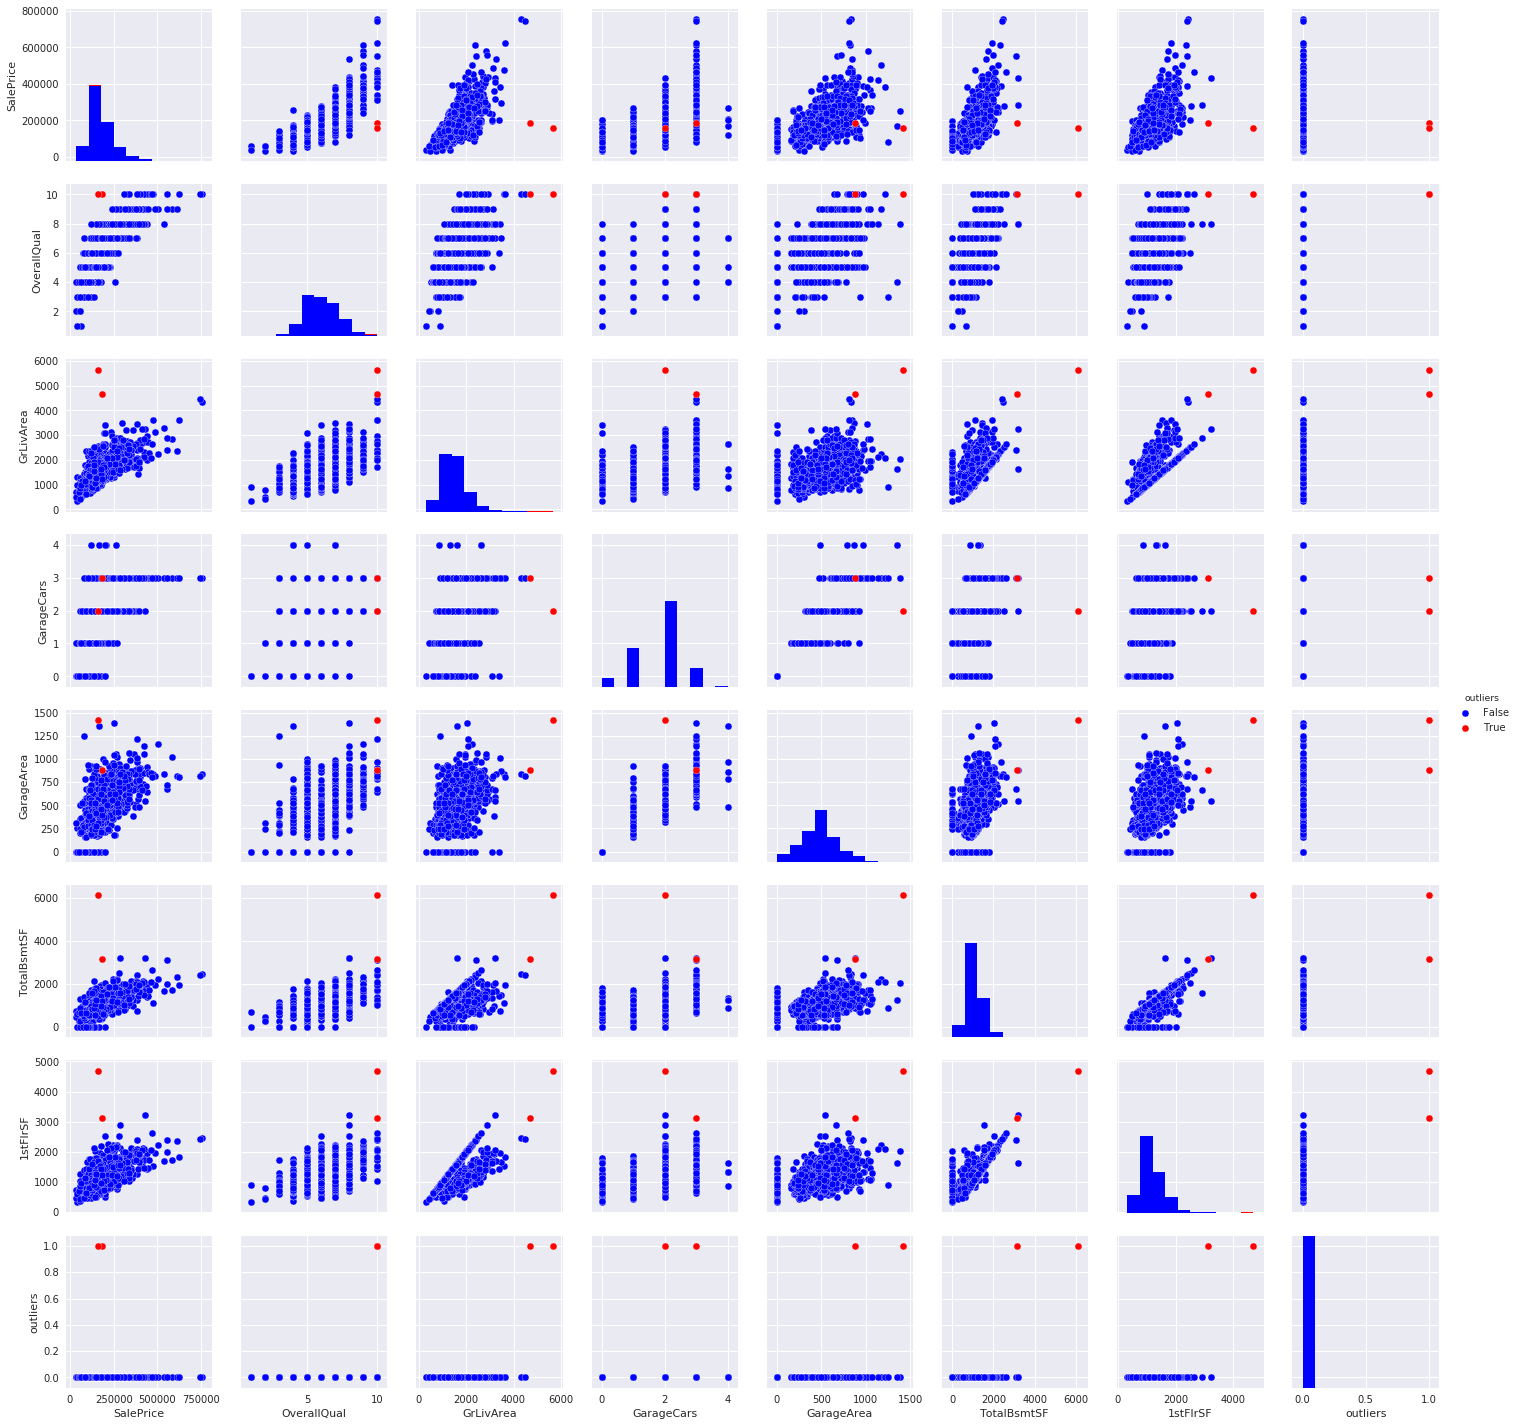

In [7]:
train_outl = train
train_outl['outliers'] = (train_outl['GrLivArea'] >4000) & (train_outl['SalePrice']<300000)

train_outl8 = train_outl[['SalePrice','OverallQual','GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 
           '1stFlrSF', 'outliers']]

sns.set()
palette ={True: 'r', False: 'b'}
sns.pairplot(train_outl8.apply(lambda x: x.fillna(x.mean()),axis=0), hue='outliers', palette=palette)
plt.show()



In [8]:
train_outl.drop(['outliers'], axis = 1, inplace = True)
train.drop(train[(train['GrLivArea'] >4000) & (train['SalePrice']<300000)].index,inplace = True)

In [9]:
print(train_outl.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [10]:
y_train = train.loc[:,'SalePrice']
train.drop(['SalePrice'], axis=1, inplace=True)

In [11]:
X = pd.concat([train, test])
print(X.shape)
print(y_train.shape)

(2917, 80)
(1458,)


## Preprocessing and feature generating..

In [12]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
display(X.iloc[0,1:5])

MSSubClass       60
MSZoning         RL
LotFrontage      65
LotArea        8450
Name: 0, dtype: object

##### Looking carefully at the features

In [13]:
pure_categorical_columns = ['MSSubClass', 'MSZoning', 'LandContour', 'LotConfig', 'BldgType', 'RoofStyle', 'RoofMatl', 
                           'MasVnrType', 'Foundation', 'Heating', 'GarageType', 'SaleType', 'SaleCondition',
                           'Neighborhood']
numerical_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
                     'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                     'GrLivArea', 'LowQualFinSF', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
                     'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
                     'PoolArea', 'MoSold','BsmtUnfSF']
bin_features = ['Street', 'CentralAir', 'MiscFeature']  #MiscFeature - 1 if present, else 0
ordinal_features = ['Alley', 'LotShape', 'Utilities', 'LandSlope', 'HouseStyle', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                   'BsmtExposure','BsmtFinType1', 'BsmtFinType2', 'Electrical', 'KitchenQual', 'Functional','FireplaceQu',
                   'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC','Fence'] 
# Alley — NA < Grvl < Pave
# LotShape — Reg < IR1 < IR2 < IR3
# Utilities — ELO < NoSeWa < NoSewr < AllPub
# LandSlope — Gtl < Mod < Sev
# HouseStyle — 1Story < 1.5Unf < 1.5Fin < 2Story < 2.5Unf < 2.5Fin < SFoyer < SLvl
# ExterQual — Po < Fa < TA < Gd < Ex
# ExterCond — Po < Fa < TA < Gd < Ex
# BsmtQual —  NA < Po < Fa < TA < Gd < Ex
# BsmtCond —  NA < Po < Fa < TA < Gd < Ex
# BsmtExposure — NA < No < Mn < Av < Gd
# BsmtFinType1 — NA < Unf < LwQ < Rec < BLQ < ALQ < GLQ
# BsmtFinType2 — NA < Unf < LwQ < Rec < BLQ < ALQ < GLQ
# Electrical —  Mix < FuseP < FuseF < FuseA < SBrkr
# KitchenQual — Po < Fa < TA < Gd < Ex
# Functional —  Sal < Sev < Maj2 < Maj1 < Mod < Min2 < Min1 < Typ
# FireplaceQu — NA < Po < Fa < TA < Gd < Ex
# GarageFinish — NA < Unf < RFn < Fin
# GarageQual — NA < Po < Fa < TA < Gd < Ex
# GarageCond — NA < Po < Fa < TA < Gd < Ex
# PavedDrive — N < P < Y
# PoolQC — NA < Po < Fa < TA < Gd < Ex
# Fence — NA < MnWw < GdWo < MnPrv < GdPrv





# Special:
# Neighborhood -- place name inside Ames. To be joined with distance to center (maybe)

#Condition1, Condition2 -- onehot..

#Exterior1st, Exterior2nd — onehot simultaneously

# YearBuilt — date. We should extract how old was the house, when was sold (YrSold). No reason to keep the date itself
# YearRemodAdd — same story here
# GarageYrBlt — add numerical — how many years have passed since that

# may be add ExterCond * ExterQual, etc



##### Getting rid of nans

In [14]:
def get_nan_columns(dataframe):
    a = dataframe.isnull().any(axis=0)
    index = a.index
    has_nans = [el for el, t in list(zip(index, list(a))) if t]
    return has_nans

In [15]:
print(get_nan_columns(X))

['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


Filling nans with **NA** for ordinals

In [16]:
for col in get_nan_columns(X):
    if col in ordinal_features:
        X[col] = X[col].fillna('NA')
for col in get_nan_columns(X):
    if col in pure_categorical_columns:
        X[col] = X[col].fillna('None')
for col in get_nan_columns(X):
    if col in numerical_features:
        X[col] = X[col].fillna(X[col].mean())
        #X[col] = X[col].fillna(0).astype(np.float32)

print(get_nan_columns(X))

['Exterior1st', 'Exterior2nd', 'GarageYrBlt', 'MiscFeature']


If MiscFeature is present, put 1

In [17]:
X['MiscFeature'] = X['MiscFeature'].fillna(0).astype(bool).astype(int)
X['MasVnrArea'] = X['MasVnrArea'].fillna(0).astype(np.float32)
X['GarageType'] = X['GarageType'].fillna('missed')
X['GarageYrBlt'] = X['GarageYrBlt'].fillna(X['GarageYrBlt'].mean())
X['MasVnrType'] = X['MasVnrType'].fillna('None')

In [18]:
print(get_nan_columns(X))

['Exterior1st', 'Exterior2nd']


In [19]:
X['Exterior1st'] = X['Exterior1st'].fillna('None')
X['Exterior2nd'] = X['Exterior2nd'].fillna('None')

In [20]:
print(get_nan_columns(X))

[]


### Building XX to feed to sklearn

- Add numerical features. They will need only scaling (in the end)

In [21]:
XX_num = X[numerical_features]

- As for ordinal ones, we should replace the values to the corresponding numbers

In [22]:
a = X[ordinal_features][:]

In [23]:
# NA < Po < Fa < TA < Gd < Ex
# NA < No < Mn < Av < Gd
# NA < Unf < LwQ < Rec < BLQ < ALQ < GLQ
# NA < Grvl < Pave
# Reg < IR1 < IR2 < IR3
# ELO < NoSeWa < NoSewr < AllPub
# Gtl < Mod < Sev
# 1Story < 1.5Unf < 1.5Fin < 2Story < 2.5Unf < 2.5Fin < SFoyer < SLvl
# Mix < FuseP < FuseF < FuseA < SBrkr
# Sal < Sev < Maj2 < Maj1 < Mod < Min2 < Min1 < Typ
# NA < Unf < RFn < Fin
# N < P < Y
# NA < MnWw < GdWo < MnPrv < GdPrv
dd = {'NA':0, 'Po':1, 'Fa':2,'TA':3,'Gd':4,'Ex':5,'No':1,'Mn':2,'Av':3,'Gd':4,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,
      'GLQ':6,'Grvl':1,'Pave':2,'Reg':0,'IR1':1,'IR2':2,'IR3':3,'ELO':0,'NoSeWa':1,'NoSewr':2,'AllPub':3,'Gtl':0,'Mod':1,
      'Sev':2,'1Story':0, '1.5Unf':1,'1.5Fin':2,'2Story':3,'2.5Unf':4,'2.5Fin':5,'SFoyer':6,'SLvl':7,'Mix':0,'FuseP':1,
     'FuseF':2,'FuseA':3,'SBrkr':4,'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7,'RFn':2,'Fin':3,
     'N':0,'P':1,'Y':2,'MnWw':1,'GdWo':2,'MnPrv':3,'GdPrv':4}
for key in dd:
    a.replace(key, dd[key], inplace=True)

In [24]:
XX_num = pd.concat([XX_num, a], axis=1)

- dealing with categoricals

In [25]:
XX_cat = pd.DataFrame()

In [26]:
for col in pure_categorical_columns:
    XX_cat = pd.concat([XX_cat, pd.get_dummies(X[col], prefix=col)], axis=1)

- Extra columns

In [27]:
ext1 = pd.get_dummies(X['Exterior1st'], prefix='1')
ext2 = pd.get_dummies(X['Exterior2nd'], prefix='2')
ext = pd.concat([ext1, ext2], axis=1)

In [28]:
cols = set([el[2:] for el in ext.columns])
for col in cols:
    coll = 'Exterior_' + col
    ext[coll] = 0
    if '1_'+col in ext.columns:
        ext[coll] += ext['1_'+col]
    if '2_'+col in ext.columns:
        ext[coll] += ext['2_'+col]
a = ext[['Exterior_' + el for el in list(cols)]]
XX_cat = pd.concat([XX_cat, a], axis=1)

In [29]:
cnd1 = pd.get_dummies(X['Condition1'], prefix='1')
cnd2 = pd.get_dummies(X['Condition2'], prefix='2')
cnd = pd.concat([cnd1, cnd2], axis=1)

In [30]:
cnd1.columns, cnd2.columns

(Index(['1_Artery', '1_Feedr', '1_Norm', '1_PosA', '1_PosN', '1_RRAe', '1_RRAn',
        '1_RRNe', '1_RRNn'],
       dtype='object'),
 Index(['2_Artery', '2_Feedr', '2_Norm', '2_PosA', '2_PosN', '2_RRAe', '2_RRAn',
        '2_RRNn'],
       dtype='object'))

In [31]:
cols = set([el[2:] for el in cnd.columns])
for col in cols:
    coll = 'Condition_' + col
    cnd[coll] = 0
    if '1_'+col in cnd.columns:
        cnd[coll] += cnd['1_'+col]
    if '2_'+col in cnd.columns:
        cnd[coll] += cnd['2_'+col]
a = cnd[['Condition_' + el for el in list(cols)]]
XX_cat = pd.concat([XX_cat, a], axis=1)

In [32]:
#XX_num['ExterOverall'] = XX_num['ExterCond'] * XX_num['ExterQual']

In [33]:
XX_num = XX_num.astype(np.float32)
XX_cat = XX_cat.astype(np.float32)

In [34]:
for c in XX_num.columns:
    if sp.stats.skew(XX_num[c]) >= 0.5:
        XX_num[str(c) + 'ln'] = np.log1p(XX_num[c])

In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
XX_num[list(XX_num.columns)] = scaler.fit_transform(XX_num[list(XX_num.columns)])

In [36]:
XX = pd.concat([XX_num, XX_cat], axis=1)

In [37]:
XX['house_age'] = X['YrSold'] - X['YearBuilt']
XX['last_remod'] = X['YrSold'] - X['YearRemodAdd']
XX['garage_age'] = X['YrSold'] - X['GarageYrBlt']

In [38]:
X = XX

XX["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
XX["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
XX["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
XX["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
XX["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]
XX["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
XX["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
XX["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
XX["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
XX["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
XX["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]

In [39]:
X = np.array(XX)
X_num = np.array(XX_num)

## PCA, KernelPCA, ManifoldLearning experiments

- PCA

In [40]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(XX)

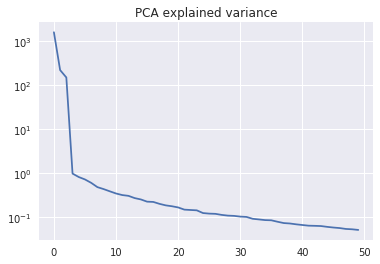

(2917, 50)


In [41]:
plt.plot(list(range(len(pca.explained_variance_))), pca.explained_variance_)
plt.yscale('log')
plt.title('PCA explained variance')
plt.show()
print(X_pca.shape)

In [42]:
print(sum(pca.explained_variance_ratio_))

0.9991604415352101


- KernelPCA

In [43]:
kpca = KernelPCA(n_components=50, kernel='rbf')
X_kpca = kpca.fit_transform(XX)

- Isomap (ManifoldLearning)

In [44]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=50)
X_manifold = iso.fit_transform(XX)

### Applying PCA to just numerical features

- PCA

In [45]:
pca = PCA(n_components=50)
X_num_pca = pca.fit_transform(XX_num)

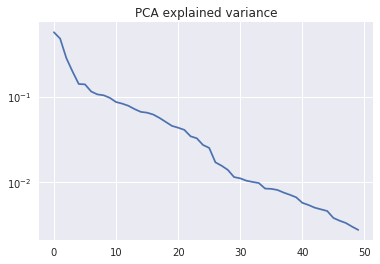

(2917, 50)
(2917, 86)


In [46]:
plt.plot(list(range(len(pca.explained_variance_))), pca.explained_variance_)
plt.yscale('log')
plt.title('PCA explained variance')
plt.show()
print(X_num_pca.shape)
print(X_num.shape)

- KPCA

In [47]:
kpca = KernelPCA(n_components=50, kernel='rbf')
X_num_kpca = kpca.fit_transform(XX_num)


- Manifold Learning

In [48]:
iso = Isomap(n_components=50)
X_num_manifold = iso.fit_transform(XX_num)

### Making train-test split, may be will be usefull later

In [49]:
random_state = 3

In [50]:
X_train = X[:y_train.shape[0],:]
X_test = X[y_train.shape[0]:,:]
X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, train_size=0.9, test_size=0.1, random_state=random_state)

In [51]:
X_train_num = X_num[:y_train.shape[0],:]
X_test_num = X_num[y_train.shape[0]:,:]
X_tr_num, X_te_num, y_tr_num, y_te_num = train_test_split(X_train_num, y_train, train_size=0.9, test_size=0.1, random_state=random_state)

In [52]:
X_train_pca = X_pca[:y_train.shape[0],:]
X_test_pca = X_pca[y_train.shape[0]:,:]
X_train_kpca = X_kpca[:y_train.shape[0],:]
X_test_kpca = X_kpca[y_train.shape[0]:,:]
X_train_isomap = X_manifold[:y_train.shape[0],:]
X_test_isomap = X_manifold[y_train.shape[0]:,:]

In [53]:
X_train_num_pca = X_num_pca[:y_train.shape[0],:]
X_test_num_pca = X_num_pca[y_train.shape[0]:,:]
X_train_num_kpca = X_num_kpca[:y_train.shape[0],:]
X_test_num_kpca = X_num_kpca[y_train.shape[0]:,:]
X_train_num_isomap = X_num_manifold[:y_train.shape[0],:]
X_test_num_isomap = X_num_manifold[y_train.shape[0]:,:]

# Running models

In [62]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, ridge_regression,ElasticNet,BayesianRidge,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import make_scorer, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm, tqdm_notebook

def rmsle_func(y, y_pred):
    return msle(y,y_pred)**0.5
rmsle = make_scorer(rmsle_func, greater_is_better=False)
mse = make_scorer(mean_squared_error, greater_is_better=False)

In [218]:
def measure_quality(clf, X_train=X_train, y_train=y_train, fit_params=None):
    return np.mean(cross_val_score(deepcopy(clf), X_train, y_train, scoring=rmsle, cv=10, n_jobs=-1, 
                                  fit_params=fit_params))

def measure_quality_mse(clf, X_train=X_train, y_train=y_train):
    return np.mean(cross_val_score(clf, X_train, y_train, scoring=mse, cv=10, n_jobs=-1))

In [64]:
class MyLinReg(LinearRegression):
    def predict(self, X):
        y = super().predict(X)
        y[y < 0] = y_train.min() * 2
        return y

class MyElasticNet(ElasticNet):
    def predict(self, X):
        y = super().predict(X)
        y[y < 0] = y_train.min() * 2
        return y

class MyBayesianRidge(BayesianRidge):
    def predict(self, X):
        y = super().predict(X)
        y[y < 0] = y_train.min() * 2
        return y

class MyLasso(Lasso):
    def predict(self, X):
        y = super().predict(X)
        y[y < 0] = y_train.min() * 2
        return y

class MySGDRegressor(SGDRegressor):
    def predict(self, X):
        y = super().predict(X)
        y[y < 0] = y_train.min() * 2
        return y

### Basic predictors' perfomance with some random hyperparameters
(trained on all features, no pca applied)

In [163]:
for clf in [MyLinReg(), MyElasticNet(), MyLasso(),
            MyBayesianRidge(),
            DecisionTreeRegressor(max_depth=15),
            RandomForestRegressor(n_estimators=500, n_jobs=-1 ),
            XGBRegressor(n_estimators=250, max_depth=15, n_jobs=-1),
            AdaBoostRegressor(AdaBoostRegressor(loss='square'), n_estimators=200),
            GradientBoostingRegressor(n_estimators=500, max_depth=15, learning_rate=0.2),
            KNeighborsRegressor(n_neighbors=10),
            SVR(kernel='rbf'),
            SVR(kernel='linear')]:
    print(str(clf.__class__.__name__).ljust(30), end=': ')
    print(round(measure_quality(clf), 5))

MyLinReg                      : -0.14769
MyElasticNet                  : -0.18254
MyLasso                       : -0.14014
MyBayesianRidge               : -0.13336
DecisionTreeRegressor         : -0.20135
RandomForestRegressor         : -0.13435
XGBRegressor                  : -0.13306
AdaBoostRegressor             : -0.17051
GradientBoostingRegressor     : -0.18597
KNeighborsRegressor           : -0.24896
SVR                           : -0.39899
SVR                           : -0.30853


## Looking at PCA results for each predictor

In [279]:
def basic_experiment(clf):
    clf_pca_num_quality = measure_quality(clf, X_train_num_pca)
    clf_quality = measure_quality(clf, X_train)
    clf_num_quality = measure_quality(clf, X_train_num)
    clf_pca_quality = measure_quality(clf, X_train_pca)
    print('pure   clf:', clf_quality)
    print('pca    clf:', clf_pca_quality)
    print('num    clf:', clf_num_quality)
    print('pcanum clf:', clf_pca_num_quality)

#### DecisionTree, RandomForest

In [144]:
basic_experiment(DecisionTreeRegressor())

pure   clf: -0.20626727809952272
pca    clf: -0.2658488556798171
num    clf: -0.20929384978511237
pcanum clf: -0.25107474326440005


In [145]:
basic_experiment(RandomForestRegressor(n_estimators=100))

pure   clf: -0.1349034774661684
pca    clf: -0.1760041128327205
num    clf: -0.14096679888896277
pcanum clf: -0.17092636020305943


#### Tree Based Boosting Methods

In [150]:
basic_experiment(GradientBoostingRegressor(n_estimators=250))

pure   clf: -0.12016007729226703
pca    clf: -0.15957570959485798
num    clf: -0.13023277994024474
pcanum clf: -0.1496471696053227


In [147]:
basic_experiment(XGBRegressor(n_estimators=250, max_depth=25, n_jobs=-1))

pure   clf: -0.13378246402986751
pca    clf: -0.16730822774238352
num    clf: -0.13943961809580613
pcanum clf: -0.1683601875926652


In [151]:
basic_experiment(AdaBoostRegressor(n_estimators=250))

pure   clf: -0.17299896212493507
pca    clf: -0.24855101487644538
num    clf: -0.1969882084411434
pcanum clf: -0.22601012423503036


#### Neighbors-based

In [152]:
basic_experiment(KNeighborsRegressor(n_neighbors=10))

pure   clf: -0.24896411560216417
pca    clf: -0.25119349141085706
num    clf: -0.19634597809766868
pcanum clf: -0.19624552056053246


In [155]:
print(measure_quality(KNeighborsRegressor(n_neighbors=10), X_train_num_kpca))
print(measure_quality(KNeighborsRegressor(n_neighbors=10), X_train_num_isomap))

-0.19479010196144123
-0.2235590137264274


#### Linear models

In [173]:
basic_experiment(MyLinReg())

pure   clf: -0.14769481346124028
pca    clf: -0.18574067709886782
num    clf: -0.17090855775676733
pcanum clf: -0.18467781611102702


In [174]:
basic_experiment(MyElasticNet())

pure   clf: -0.18254134266508354
pca    clf: -0.18451733675395066
num    clf: -0.2576328279252821
pcanum clf: -0.2576202326404291


In [175]:
basic_experiment(MyLasso())

pure   clf: -0.1401366671512035
pca    clf: -0.18570464720761634
num    clf: -0.1576642689347768
pcanum clf: -0.18436164575163422


#### SVM (both linear and nonlinear and both SVR and SVC)

SVC obviously yields warnings, as there are too many classes, so let's suppress them

In [78]:
import warnings
warnings.filterwarnings("ignore")

- SVR

In [169]:
basic_experiment(SVR(kernel='linear'))

pure   clf: -0.3085252514032447
pca    clf: -0.3085249612123361
num    clf: -0.39675615744978043
pcanum clf: -0.3967561340771692


In [170]:
basic_experiment(SVR(kernel='rbf'))

pure   clf: -0.3989858660857926
pca    clf: -0.3992636240868195
num    clf: -0.39944154126843234
pcanum clf: -0.3994051499376001


- SVC

In [172]:
basic_experiment(SVC(kernel='rbf'))

pure   clf: -0.27097146093458163
pca    clf: -0.25584834162215625
num    clf: -0.28834958043057085
pcanum clf: -0.28834958043057085


In [171]:
basic_experiment(SVC(kernel='linear'))

pure   clf: -0.21964355281718265
pca    clf: -0.2368413415578449
num    clf: -0.1850019535273522
pcanum clf: -0.18464484434389378


In [177]:
print(measure_quality(SVC(kernel='linear'), X_train_num_pca))
print(measure_quality(SVC(kernel='linear'), X_train_num_kpca))
print(measure_quality(SVC(kernel='linear'), X_train_num_isomap))

-0.18464484434389378
-0.28834958043057085
-0.24833052633580413


Sad, but true, SVC works better, than SVM

### Results interpretation

As we can see, pca rarely improves the results and does so only when applied to numerical features and just for some linear and neighborhood models

So in what follows, we are interested mostly in the pure data, without any pca applied, with the known exceptions.

## Looking for the best hyperparameters

### RandomForest

In [215]:
param_grid = {
    'n_estimators': [50, 100, 250, 500],
    #'criterion': ['mse'],
    'max_depth': [5,10,None]
}

In [216]:
gcv = GridSearchCV(RandomForestRegressor(n_jobs=-1), param_grid=param_grid, n_jobs=-1, cv=5,
                   scoring=rmsle, verbose=1, return_train_score=True)
_ = gcv.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.3min finished


In [189]:
print(gcv.best_params_)
print(gcv.best_score_)

{'max_depth': None, 'n_estimators': 100}
-0.13593960222877124


In [194]:
measure_quality(RandomForestRegressor(max_depth=None, n_estimators=50, n_jobs=-1))

-0.135910066091714

In [190]:
measure_quality(RandomForestRegressor(max_depth=None, n_estimators=100, n_jobs=-1))

-0.13495221102764093

In [191]:
measure_quality(RandomForestRegressor(max_depth=None, n_estimators=200, n_jobs=-1))

-0.1349369376389588

- trying MAE as the loss function

In [192]:
measure_quality(RandomForestRegressor(max_depth=None, n_estimators=100, criterion='mae', n_jobs=-1))

-0.13620000958259312

mae slow and inefficient $\Rightarrow$ don't use it:

### KNeighboursRegressor

In [195]:
param_grid = {
    'n_neighbors': list(range(1,30,2)),
    'leaf_size': [10, 30, 50],
    'p': [1, 2],
    'weights': ['uniform', 'distance']
}

In [199]:
gcv = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs=-1, scoring=rmsle, return_train_score=True)
_ = gcv.fit(X_train_num_kpca, y_train)

In [200]:
print(gcv.best_score_)
print(gcv.best_params_)

-0.19473424833311367
{'leaf_size': 10, 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}


In [210]:
measure_quality(KNeighborsRegressor(leaf_size=10, n_neighbors=10, p=1, weights='distance'), X_train_num_kpca)

-0.18938224852947894

(Results are a bit different due to the difference in cv numbers and randomization) 

### XGBoost

In [232]:
param_grid = {
    'max_depth': [2,3,4,5],
    'n_estimators': [500,300,200],
    'subsample':[0.7, 0.8, 0.9, 1],
    'colsample_bytree':[0.8, 1]
}

In [233]:
gcv = GridSearchCV(XGBRegressor(), param_grid, n_jobs=-1, scoring=rmsle, return_train_score=True)
_ = gcv.fit(X_train, y_train)

In [234]:
print(gcv.best_score_)
print(gcv.best_params_)

-0.11881878408231372
{'colsample_bytree': 1, 'max_depth': 2, 'n_estimators': 500, 'subsample': 0.7}


In [235]:
measure_quality(XGBRegressor(n_estimators=500, max_depth=2, subsample=0.7))

-0.11457733320841372

In [237]:
measure_quality(XGBRegressor(n_estimators=700, max_depth=2, subsample=0.7))

-0.11406124184438013

In [238]:
measure_quality(XGBRegressor(n_estimators=1000, max_depth=2, subsample=0.7))

-0.11437931723372619

### Gradient Boosting Regressor from sklearn

In [242]:
param_grid = {
    'loss': ['ls'],
    'learning_rate': [0.1],
    'n_estimators': [500, 1000],
    'subsample': [0.7, 0.8, 0.9, 1],
    'max_depth': [2, 3, 5]
}

In [243]:
gcv = GridSearchCV(GradientBoostingRegressor(), param_grid, n_jobs=-1, scoring=rmsle, return_train_score=True)
_ = gcv.fit(X_train, y_train)

In [244]:
print(gcv.best_score_)
print(gcv.best_params_)

-0.12071851122124626
{'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}


In [245]:
measure_quality(GradientBoostingRegressor(n_estimators=700, subsample=0.7))

-0.11554454828200396

### SGDRegressor

In [260]:
param_grid={
    'penalty': ['l2'],
    'alpha': [0.0001, 0.005, 0.01, 0.05, 0.1],
    'max_iter': [1e3]
}

In [261]:
gcv = GridSearchCV(SGDRegressor(), param_grid, n_jobs=-1, scoring=mse, return_train_score=True)
_ = gcv.fit(X_train, y_train)

In [262]:
print(gcv.best_score_)
print(gcv.best_params_)

-4.8901846546329866e+22
{'alpha': 0.1, 'max_iter': 1000.0, 'penalty': 'l2'}


In [265]:
 measure_quality(MySGDRegressor(max_iter=1000, penalty='l2', alpha=0.1))

-9.311339451028278

too bad

### SVR, SVC

In [266]:
param_grid={
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'C': [10, 1, 0.1, 0.01]
}

In [271]:
gcv = GridSearchCV(SVR(), param_grid, n_jobs=-1, scoring=rmsle, return_train_score=True)
_ = gcv.fit(X_train, y_train)
print(gcv.best_score_)
print(gcv.best_params_)

-0.2868801033211419
{'C': 10, 'kernel': 'linear'}


In [270]:
gcv = GridSearchCV(SVC(), param_grid, n_jobs=-1, scoring=rmsle, return_train_score=True)
_ = gcv.fit(X_train_num_pca, y_train)
print(gcv.best_score_)
print(gcv.best_params_)

-0.2459530214080826
{'C': 1, 'kernel': 'linear'}


### Decision Tree

In [272]:
param_grid={
    'criterion': ['mse', 'mae'],
    'max_depth': [10, 20, 30, 40, 50, 70, 100, None],
    'min_samples_split': [2,4,6,8,10],
    'min_samples_leaf': [1,3,5,7,9]
}

In [273]:
gcv = GridSearchCV(DecisionTreeRegressor(), param_grid, n_jobs=-1, scoring=rmsle, return_train_score=True)
_ = gcv.fit(X_train, y_train)
print(gcv.best_score_)
print(gcv.best_params_)

-0.17994523257912598
{'criterion': 'mae', 'max_depth': 50, 'min_samples_leaf': 7, 'min_samples_split': 8}


In [274]:
measure_quality(DecisionTreeRegressor(criterion='mae', max_depth=10, min_samples_split=2, min_samples_leaf=6))

-0.1739414471487947

### Adaboost

In [57]:
param_grid={
    'n_estimators': [100, 500],
    'loss': ['linear', 'square', 'exponential']
}

In [58]:
gcv = GridSearchCV(AdaBoostRegressor(), param_grid, n_jobs=-1, scoring=rmsle, return_train_score=True)
_ = gcv.fit(X_train, y_train)
print(gcv.best_score_)
print(gcv.best_params_)

-0.17226398591933456
{'loss': 'linear', 'n_estimators': 500}


In [68]:
gcv = GridSearchCV(AdaBoostRegressor(), param_grid, n_jobs=-1, scoring=rmsle, return_train_score=True)
_ = gcv.fit(X_train_num, y_train)
print(gcv.best_score_)
print(gcv.best_params_)

-0.1891024827847244
{'loss': 'exponential', 'n_estimators': 100}


In [71]:
measure_quality(AdaBoostRegressor(loss='linear', n_estimators=500), X_train_num)

-0.1985728298815277

In [70]:
measure_quality(AdaBoostRegressor(loss='linear', n_estimators=500))

-0.17451693883209987

### Linear models

In [92]:
param_grid={
    'alpha': [0.1, 0.5, 1, 5, 10, 20, 40, 50, 100, 1000],
    'max_iter': [500, 750, 1000]
}

In [93]:
gcv = GridSearchCV(MyLasso(), param_grid, n_jobs=-1, scoring=rmsle, return_train_score=True)
_ = gcv.fit(X_train, y_train)
print(gcv.best_score_)
print(gcv.best_params_)

-0.12801986658465048
{'alpha': 100, 'max_iter': 500}


In [96]:
measure_quality(MyLasso(alpha=100, max_iter=500))

-0.12406878142079927

### BayesianRidge

In [276]:
param_grid={
    'alpha_1':[1e-3,1e-4,1e-5,1e-6,1e-7],
    'alpha_2':[1e-3,1e-4,1e-5,1e-6,1e-7],
    'lambda_1':[1e-3,1e-4,1e-5,1e-6,1e-7],
    'lambda_2':[1e-3,1e-4,1e-5,1e-6,1e-7],
}

In [277]:
gcv = GridSearchCV(BayesianRidge(), param_grid, n_jobs=-1, scoring=rmsle, return_train_score=True)
_ = gcv.fit(X_train, y_train)
print(gcv.best_score_)
print(gcv.best_params_)

-0.14398267435840054
{'alpha_1': 1e-07, 'alpha_2': 1e-05, 'lambda_1': 0.001, 'lambda_2': 1e-06}


In [278]:
measure_quality(BayesianRidge(alpha_1=1e-7,alpha_2=1e-5,lambda_1=0.001, lambda_2=1e-6))

-0.13335603295121604

## Ensembling

We are about to take some best predictors to increase (hopefully) the overall quality. <br>
For that we consider 2 strategies: Blending and Stacking.

#### Blending

In [285]:
clf1 = GradientBoostingRegressor(n_estimators=700, subsample=0.7)
clf2 = XGBRegressor(n_estimators=1000, max_depth=2, subsample=0.7)
clf3 = RandomForestRegressor(max_depth=None, n_estimators=100, n_jobs=-1)
clf4 = MyLasso(alpha=100, max_iter=500)
clf5 = KNeighborsRegressor(leaf_size=10, n_neighbors=10, p=1, weights='distance')
clfs = [clf1, clf2, clf3, clf4, clf5]

In [286]:
from sklearn.base import BaseEstimator
class BlendRegressor(BaseEstimator):
    def __init__(self, clfs, weights=None):
        if clfs is None:
            clfs = deepcopy([clf1, clf2, clf3, clf4, clf5])
        if weights is None:
            weights = np.array([1/len(clfs)]*len(clfs))
        else:
            weights /= np.sum(weights)
        self._weights = weights
        self._clfs = deepcopy(clfs)

    def fit(self, X, y, weights=None):
        if weights:
            self._weights = weights
            self._weights /= np.sum(weights)
        for clf in self._clfs:
            clf.fit(X, y)
        return self

    def predict(self, X):
        result = np.zeros(X.shape[0])
        for clf, weight in zip(self._clfs, self._weights):
            result += clf.predict(X) * weight
        result[result < y_train.min()] = y_train.min()
        return np.round(result)

In [287]:
br = BlendRegressor(clfs, weights=[4,4,3,3,1])
br.fit(X_tr, y_tr)
rmsle_func(y_te, br.predict(X_te))

0.11541919910704217

In [173]:
measure_quality(BlendRegressor(clfs, weights=[4,4,3,3,1]))

-0.11575502318895833

That's an improvement!

In [235]:
param_grid={
    'weights': [None, [2,2,1,1,1], [5,5,5,1,1], [3,3,3,3,1],[4,4,3,3,1],[4,4,3,3,0],[3,2,1,1,0],
               [3,3,0,2,1], [4,4,0,2,2], [3,3,0,2,0]]
}

In [236]:
gcv = GridSearchCV(BlendRegressor(clfs), param_grid, n_jobs=-1, scoring=rmsle, return_train_score=True)
_ = gcv.fit(X_train, y_train)
print(gcv.best_score_)
print(gcv.best_params_)

-0.11962623495115368
{'weights': [4, 4, 0, 2, 2]}


In [229]:
measure_quality(BlendRegressor(clfs), fit_params={'weights':[4,4,4,2,1]})

-0.11334889984601056

In [230]:
measure_quality(BlendRegressor(clfs), fit_params={'weights':[4,4,4,2,0]})

-0.11318363029597482

In [231]:
measure_quality(BlendRegressor(clfs), fit_params={'weights':[3,3,0,2,0]})

-0.1105865128138757

In [232]:
measure_quality(BlendRegressor(clfs), fit_params={'weights':[3,3,0,2,1]})

-0.11064607377142728

In [228]:
measure_quality(BlendRegressor(clfs), fit_params={'weights':[4,4,3,3,1]})

-0.11216636703228526

In [237]:
measure_quality(BlendRegressor(clfs), fit_params={'weights':[4,4,0,2,2]})

-0.11264644847651999

In [238]:
measure_quality(BlendRegressor(clfs), fit_params={'weights':[4,4,0,2,0]})

-0.11188020154515632

In [239]:
measure_quality(BlendRegressor(clfs), fit_params={'weights':[4,3,0,2,0]})

-0.11205696667969745

This is a significant improvement as compared to the pure classifiers

#### Stacking

In [240]:
from mlxtend.regressor import StackingRegressor

In [245]:
stacking_regressor = StackingRegressor(regressors=clfs[:4], meta_regressor=LinearRegression())

In [246]:
measure_quality(stacking_regressor)

-0.12601732932243984

In [251]:
stacking_regressor = StackingRegressor(regressors=clfs[:4], meta_regressor=clf4)

In [252]:
measure_quality(stacking_regressor)

-0.12072035824398189

In [258]:
stacking_regressor = StackingRegressor(regressors=clfs[:2] + clfs[3:4], meta_regressor=clf4)

In [259]:
measure_quality(stacking_regressor)

-0.12242054268064173

In [256]:
stacking_regressor = StackingRegressor(regressors=clfs[:2], meta_regressor=clf4)

In [257]:
measure_quality(stacking_regressor)

-0.12140896731614012

In [262]:
measure_quality(StackingRegressor(regressors=clfs[:2]+[clfs[3]], meta_regressor=clf1, store_train_meta_features=True))

-0.12127050137855222

In [264]:
measure_quality(StackingRegressor(regressors=clfs[:1]+[clfs[3]], meta_regressor=BlendRegressor(clfs, weights=[3,3,0,2,0]), store_train_meta_features=True))

-0.11787683315003727

In [266]:
measure_quality(StackingRegressor(regressors=clfs[:1]+[clfs[3]], meta_regressor=BlendRegressor(clfs, weights=[3,3,0,1,0]), store_train_meta_features=False))

-0.11787683315003727

No improvemnts

## For kaggle

In [268]:
clf1 = GradientBoostingRegressor(n_estimators=700, subsample=0.7)
clf2 = XGBRegressor(n_estimators=1000, max_depth=2, subsample=0.7)
clf3 = RandomForestRegressor(max_depth=None, n_estimators=100, n_jobs=-1)
clf4 = MyLasso(alpha=100, max_iter=500)
clf5 = KNeighborsRegressor(leaf_size=10, n_neighbors=10, p=1, weights='distance')
clfs = [clf1, clf2, clf3, clf4, clf5]

In [274]:
clf = BlendRegressor(clfs, weights=[3,3,0,2,0])
clf.fit(X_train, y_train)
y_test = clf.predict(X_test)
y_test = np.round(y_test).astype(np.int32)
print(y_test.shape)
y_test = pd.DataFrame({'Id':list(range(1461,2920)), 'SalePrice':y_test})
pd.DataFrame.to_csv(y_test, 'prec.csv', index=False)

(1459,)
